In [6]:
import matplotlib.pyplot as plt
import os
from google.colab import files

import zipfile
import os
import shutil
import tensorflow as tf
import random

In [10]:
#import data
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## **Data Preparation**

In [11]:
!kaggle datasets download -d vencerlanz09/sea-animals-image-dataste

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste
License(s): other
sea-animals-image-dataste.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:


# Path ke file ZIP
zip_path = '/content/sea-animals-image-dataste.zip'

# Nama folder baru untuk ekstraksi
extract_folder_name = 'dataset'

# Path lengkap ke folder ekstraksi
extract_folder_path = os.path.join('/content', extract_folder_name)

# Membuat folder ekstraksi jika belum ada
os.makedirs(extract_folder_path, exist_ok=True)

# Membuka file ZIP dan mengekstraknya ke folder baru
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

print(f"File diekstrak ke folder: {extract_folder_path}")


File diekstrak ke folder: /content/dataset


In [13]:
# Walk through each directory\n
import os
print(os.listdir("/content/dataset"))

['Clams', 'Sharks', 'Turtle_Tortoise', 'Penguin', 'Sea Urchins', 'Corals', 'Nudibranchs', 'Starfish', 'Shrimp', 'Fish', 'Lobster', 'Sea Rays', 'Squid', 'Whale', 'Jelly Fish', 'Seal', 'Crabs', 'Seahorse', 'Puffers', 'Octopus', 'Otter', 'Eel', 'Dolphin']


In [14]:
class_names= ['Fish', 'Octopus', 'Jelly Fish', 'Crabs']

In [15]:
import os
import shutil
import random

# original path
original_dataset_dir ="/content/dataset"

# new paths for training and validation sets
base_dir = "/content/dataset-2"
os.mkdir(base_dir)

# new folder for training set
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# new folder for validation set
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# Eğitim ve validation için her bir sınıfın klasörleri
classes = class_names

for cls in classes:
    cls_dir = os.path.join(original_dataset_dir, cls)
    files = os.listdir(cls_dir)
    random.shuffle(files)

    # split dataset to training and validation
    split_point = int(0.8 * len(files))   # training percentage is 0.7 --> %70
    train_files = files[:split_point]
    validation_files = files[split_point:]

    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir)

    validation_cls_dir = os.path.join(validation_dir, cls)
    os.makedirs(validation_cls_dir)

    # copy files to the folders
    for file in train_files:
        src = os.path.join(cls_dir, file)
        dst = os.path.join(train_cls_dir, file)
        shutil.copyfile(src, dst)

    for file in validation_files:
        src = os.path.join(cls_dir, file)
        dst = os.path.join(validation_cls_dir, file)
        shutil.copyfile(src, dst)

FileExistsError: [Errno 17] File exists: '/content/dataset-2'

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dir="/content/dataset-2/train"
validation_dir="/content/dataset-2/validation"

image_size = (244,244)
batch_size = 32
seed = 999

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)



train_data = train_datagen.flow_from_directory(
    training_dir,
    class_mode='sparse',
    target_size=image_size,
    batch_size=batch_size,
    seed=seed
)

valid_data = validation_datagen.flow_from_directory(
    validation_dir,
    class_mode='sparse',
    target_size=image_size,
    batch_size=batch_size,
    seed=seed
)

Found 1919 images belonging to 4 classes.
Found 481 images belonging to 4 classes.


# **Modeling**

# **VGG**

In [24]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layer
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

vgg_model = tf.keras.models.Sequential([
  conv_base,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])

# Print model summary
vgg_model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 21138500 (80.64 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [25]:
vgg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
60/60 [==============================] - 94s 1s/step - loss: 2.3834 - accuracy: 0.3278 - val_loss: 1.3673 - val_accuracy: 0.3514
Epoch 2/20
60/60 [==============================] - 43s 710ms/step - loss: 1.2438 - accuracy: 0.3523 - val_loss: 1.1003 - val_accuracy: 0.3597
Epoch 3/20
60/60 [==============================] - 52s 858ms/step - loss: 1.0969 - accuracy: 0.4977 - val_loss: 1.1727 - val_accuracy: 0.4823
Epoch 4/20
60/60 [==============================] - 42s 700ms/step - loss: 1.0537 - accuracy: 0.5388 - val_loss: 1.0707 - val_accuracy: 0.4387
Epoch 5/20
60/60 [==============================] - 42s 703ms/step - loss: 0.9957 - accuracy: 0.5779 - val_loss: 0.9302 - val_accuracy: 0.5800
Epoch 6/20
60/60 [==============================] - 42s 696ms/step - loss: 0.9747 - accuracy: 0.5816 - val_loss: 0.9097 - val_accuracy: 0.6071
Epoch 7/20
60/60 [==============================] - 43s 708ms/step - loss: 0.9225 - accuracy: 0.6029 - val_loss: 0.8489 - val_accuracy: 0.6674
Ep

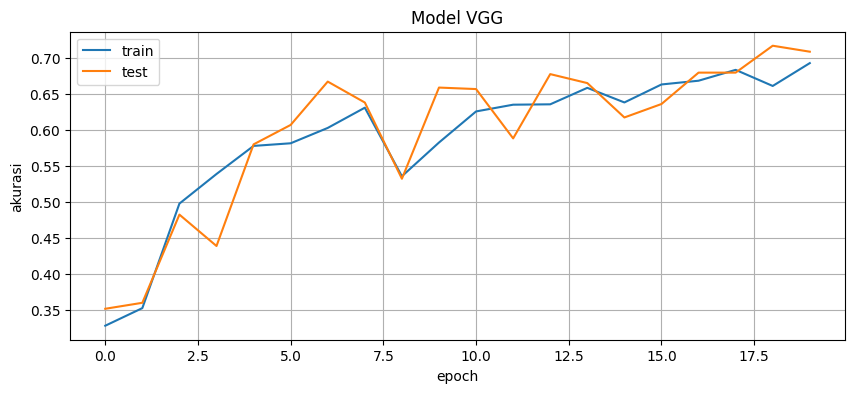

In [27]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model VGG')
plt.ylabel('akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# **ResNet**

In [7]:
pretrained_model= tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))



In [8]:
ResNet_model = tf.keras.models.Sequential([
  pretrained_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

ResNet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 90699140 (345.99 MB)
Trainable params: 90646020 (345.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [18]:
history = ResNet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
60/60 [==============================] - 85s 781ms/step - loss: 6.8172 - accuracy: 0.5836 - val_loss: 417698.5938 - val_accuracy: 0.3514
Epoch 2/20
60/60 [==============================] - 41s 675ms/step - loss: 1.0227 - accuracy: 0.6154 - val_loss: 2.0270 - val_accuracy: 0.2058
Epoch 3/20
60/60 [==============================] - 41s 674ms/step - loss: 0.9396 - accuracy: 0.6717 - val_loss: 2.2190 - val_accuracy: 0.3514
Epoch 4/20
60/60 [==============================] - 40s 671ms/step - loss: 0.9288 - accuracy: 0.6910 - val_loss: 1.4179 - val_accuracy: 0.2058
Epoch 5/20
60/60 [==============================] - 40s 670ms/step - loss: 0.7895 - accuracy: 0.7264 - val_loss: 1.5151 - val_accuracy: 0.3514
Epoch 6/20
60/60 [==============================] - 40s 670ms/step - loss: 0.6873 - accuracy: 0.7348 - val_loss: 1.5219 - val_accuracy: 0.4220
Epoch 7/20
60/60 [==============================] - 41s 671ms/step - loss: 0.6833 - accuracy: 0.7275 - val_loss: 1.4554 - val_accuracy: 0

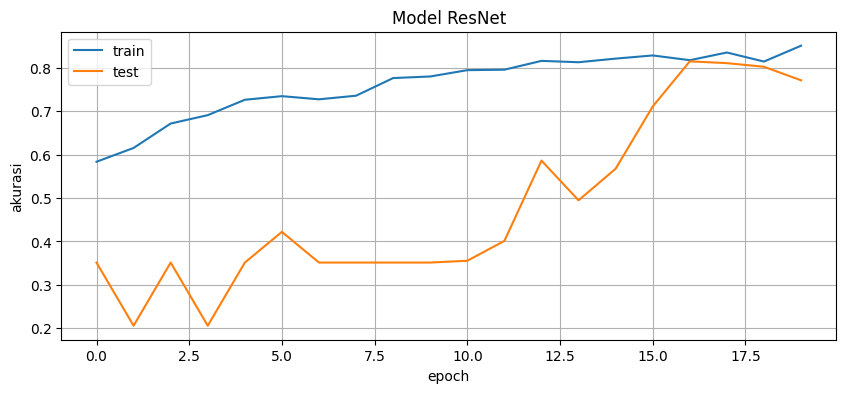

In [19]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model ResNet')
plt.ylabel('akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()